<a href="https://colab.research.google.com/github/EuroLifeWay/Project-pairs-trading/blob/main/Tests_%D0%9E%D1%80%D0%BD%D1%88%D1%82%D0%B5%D0%B9%D0%BD_%D0%A3%D0%BB%D0%B5%D0%BD%D0%B1%D0%B5%D0%BA_(OU)_Augmented_Dickey_Fuller_(ADF)_Kalman_Filter_GaussianHMM_%D0%BD%D0%B0_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 4.1. Процесс Орнштейна-Уленбека (OU)
 является фундаментальной моделью для описания возврата к среднему. Ниже приведен пример кода на Python, который симулирует и визуализирует траекторию этого процесса.


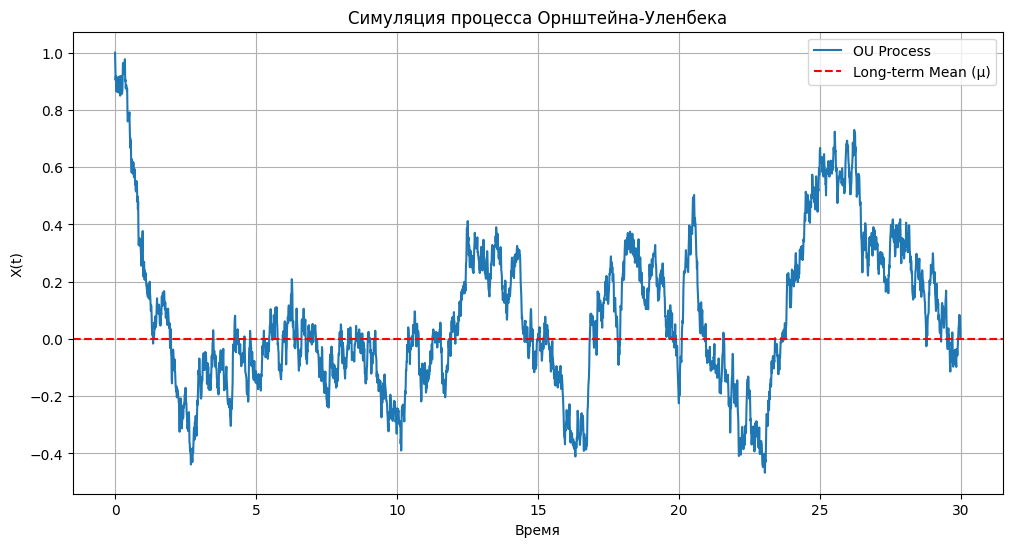

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры процесса OU
theta = 0.7      # Скорость возврата к среднему
mu = 0.0         # Долгосрочное среднее
sigma = 0.3      # Волатильность
X0 = 1.0         # Начальное значение
T = 30.0         # Общее время
dt = 0.01        # Шаг времени
N = int(T / dt)  # Количество временных шагов

# Предварительное выделение массива для эффективности
X = np.zeros(N)
X[0] = X0

# Генерация процесса OU
for t in range(1, N):
    dW = np.sqrt(dt) * np.random.normal(0, 1)
    X[t] = X[t-1] + theta * (mu - X[t-1]) * dt + sigma * dW

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, T, N), X, label='OU Process')
plt.axhline(y=mu, color='r', linestyle='--', label='Long-term Mean (μ)')
plt.title("Симуляция процесса Орнштейна-Уленбека")
plt.xlabel("Время")
plt.ylabel("X(t)")
plt.legend()
plt.grid(True)
plt.show()

Этот код демонстрирует, как процесс, начавшийся с начального значения X0 = 1.0, со временем колеблется вокруг долгосрочного среднего μ = 0.0, иллюстрируя фундаментальное свойство возврата к среднему, которое эксплуатируется в парных стратегиях.



---



## 4.2. Проверка стационарности временного ряда с помощью теста ADF
Тест Дики-Фуллера с дополнительными лагами (Augmented Dickey-Fuller, ADF) является стандартным методом для проверки стационарности временного ряда. Ниже приведен пример его применения к ценам закрытия акции Apple (AAPL).

In [ ]:
import yfinance as yf
from statsmodels.tsa.stattools import adfuller

# Загрузка данных
data = yf.download("AAPL", start="2020-01-01", end="2023-01-01")
price = data['Close']

# Выполнение теста ADF
result = adfuller(price)

# Вывод результатов
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Интерпретация
if result[1] > 0.05:
    print("Ряд, вероятно, нестационарен (не отвергаем нулевую гипотезу о наличии единичного корня).")
else:
    print("Ряд, вероятно, стационарен (отвергаем нулевую гипотезу).")

/tmp/ipython-input-4145581057.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2020-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed

ADF Statistic: -1.888908
p-value: 0.337297
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Ряд, вероятно, нестационарен (не отвергаем нулевую гипотезу о наличии единичного корня).


В этом примере мы загружаем исторические данные и применяем функцию adfuller из библиотеки statsmodels. Результат включает ADF-статистику, p-value и критические значения. Если p-value больше уровня значимости (например, 0.05), мы не можем отвергнуть нулевую гипотезу о наличии единичного корня, что означает, что ряд, вероятно, нестационарен.

## 4.3. Реализация парного трейдинга с динамическим хедж-коэффициентом (фильтр Калмана)
Фильтр Калмана может быть использован для динамической оценки коэффициента хеджирования в парном трейдинге, что делает стратегию более адаптивной. Ниже приведен упрощенный пример.

In [ ]:
# !pip install pykalman

/tmp/ipython-input-1110016442.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(['GLD', 'GDX'], start="2020-01-01", end="2023-01-01")
[*********************100%***********************]  2 of 2 completed


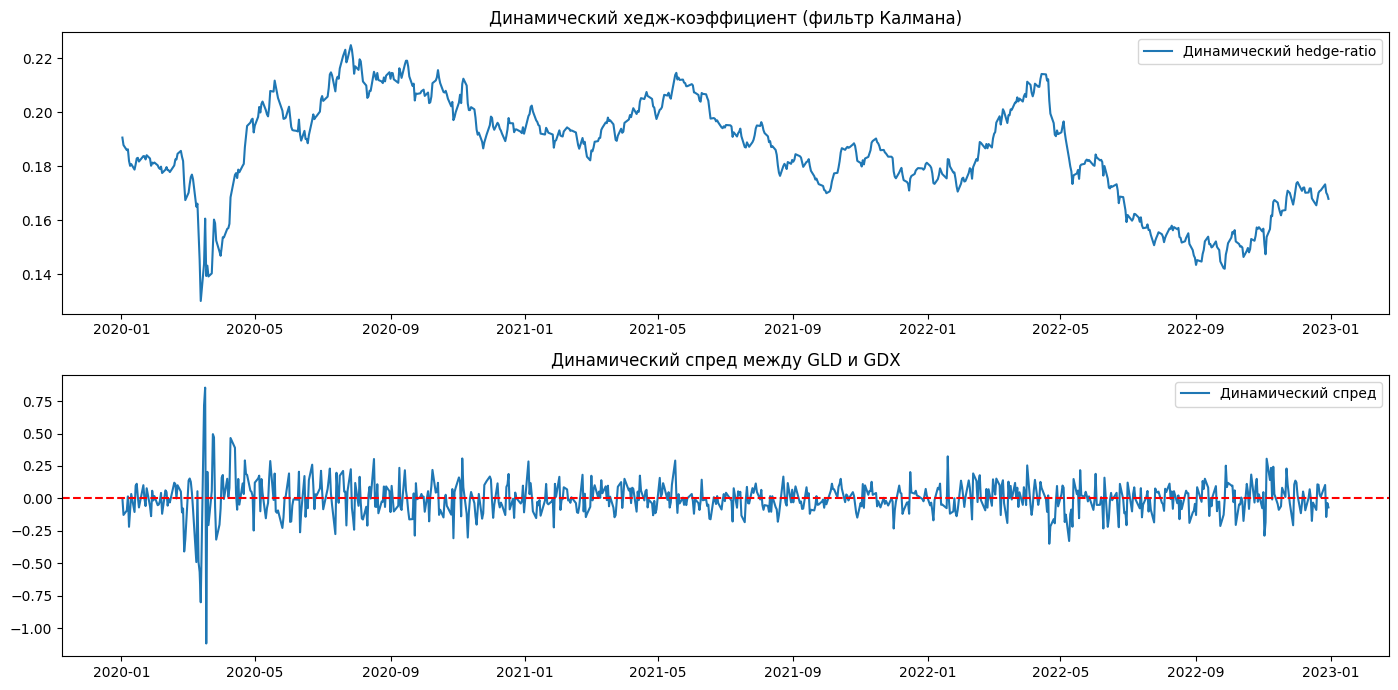

In [ ]:
import yfinance as yf
import numpy as np
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

# 1. Загрузка данных
data = yf.download(['GLD', 'GDX'], start="2020-01-01", end="2023-01-01")
prices = data['Close'].dropna()
x = prices['GLD'].values      # независимая переменная
y = prices['GDX'].values      # зависимая переменная

# 2. Подготавливаем observation_matrices как 3-D массив (T, 1, 2)
obs_mat = np.column_stack([np.ones_like(x), x])  # (T, 2)
obs_mat = obs_mat[:, np.newaxis, :]              # (T, 1, 2)

# 3. Инициализация фильтра Калмана
kf = KalmanFilter(
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    initial_state_mean=np.zeros(2),
    initial_state_covariance=np.eye(2),
    observation_covariance=1.0,
    transition_covariance=np.eye(2) * 1e-4
)

# 4. Оценка состояний
state_means, _ = kf.filter(y)

# 5. Динамический хедж-коэффициент и спред
hedge_ratios = state_means[:, 1]
spread = y - (state_means[:, 0] + hedge_ratios * x)

# 6. Визуализация
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(prices.index, hedge_ratios, label='Динамический hedge-ratio')
plt.title('Динамический хедж-коэффициент (фильтр Калмана)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(prices.index, spread, label='Динамический спред')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Динамический спред между GLD и GDX')
plt.legend()
plt.tight_layout()
plt.show()

В этом примере фильтр Калмана используется для оценки коэффициента наклона (hedge ratio) в линейной регрессии GDX на GLD. Этот коэффициент обновляется на каждом шаге, что позволяет спреду адаптироваться к изменяющимся рыночным условиям.



---





---



# 4.4. Обнаружение рыночных режимов с использованием скрытых марковских моделей
Скрытые марковские модели (HMM) предоставляют практический способ обнаружения и использования рыночных режимов в торговых стратегиях. Ниже приведен подробный пример реализации HMM на Python с использованием библиотеки hmmlearn для анализа доходности и диапазона цен акции SPY (ETF, отслеживающий S&P 500) . Этот пример демонстрирует, как можно обучить модель для выявления различных рыночных состояний и визуализировать результаты.
### Шаг 1: Установка необходимых библиотек и импорт данных
Первым шагом является импорт необходимых библиотек и загрузка финансовых данных. В данном примере используются yfinance для загрузки данных, numpy и pandas для обработки данных, а также hmmlearn для построения и обучения модели.

In [ ]:
# !pip install hmmlearn

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from hmmlearn import hmm

# Загрузка исторических данных для SPY
data = yf.download("SPY")

# Вычисление логарифмических доходностей
returns = np.log(data['Close'] / data['Close'].shift(1))

# Вычисление дневного диапазона цен (High - Low) как меры волатильности
price_range = data['High'] - data['Low']

# Объединение признаков в один DataFrame и удаление пропущенных значений
features = pd.concat([returns, price_range], axis=1).dropna()
features.columns = ["returns", "range"]

/tmp/ipython-input-2156417323.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("SPY")
[*********************100%***********************]  1 of 1 completed


В этом коде создаются два признака для модели: returns
(логарифмические доходности) и range (диапазон цен). Логарифмические доходности являются стандартной мерой доходности в финансах, а диапазон цен служит индикатором внутридневной волатильности. Использование этих двух признаков позволяет модели учитывать как направление, так и интенсивность движения цен.

### Шаг 2: Создание и обучение модели HMM
Далее создается экземпляр модели GaussianHMM, которая предполагает, что наблюдаемые признаки в каждом скрытом состоянии распределены по многомерному нормальному закону. В данном случае модель настраивается на три скрытых состояния, которые могут интерпретироваться как различные рыночные режимы (например, "восходящий", "боковой", "нисходящий").

In [ ]:
# Инициализация модели GaussianHMM с 3 скрытыми состояниями
model = hmm.GaussianHMM(
    n_components=3,           # Количество скрытых состояний (режимов)
    covariance_type="full",   # Использовать полную ковариационную матрицу для каждого состояния
    n_iter=1000               # Максимальное количество итераций алгоритма EM
)

# Обучение модели на подготовленных признаках
model.fit(features)

GaussianHMM(covariance_type='full', n_components=3, n_iter=1000)

Параметр covariance_type="full" означает, что для каждого скрытого состояния будет оценена полная ковариационная матрица, что позволяет модели учитывать корреляцию между признаками returns и range. Алгоритм обучения (Expectation-Maximization) итеративно корректирует параметры модели (матрицу переходов, начальные вероятности и параметры нормальных распределений) для максимизации правдоподобия наблюдаемых данных.

### Проверьте форму features перед предсказанием:

In [ ]:
print(features.shape)   # должно быть (T, 2)

(21, 2)


Если она (T, 1) или (21, 1), это значит, что второй признак (range) не добавился корректно. Обычно это происходит, когда High и Low совпадают (например, в некоторых датах) и range становится 0, а при dropna() строки удаляются, и форма искажается.

### Шаг 3: Предсказание скрытых состояний и визуализация результатов
После обучения модели можно использовать метод predict() для определения наиболее вероятной последовательности скрытых состояний для наблюдаемых данных. Это позволяет "расшифровать" рыночные режимы на историческом графике.

<Axes: >

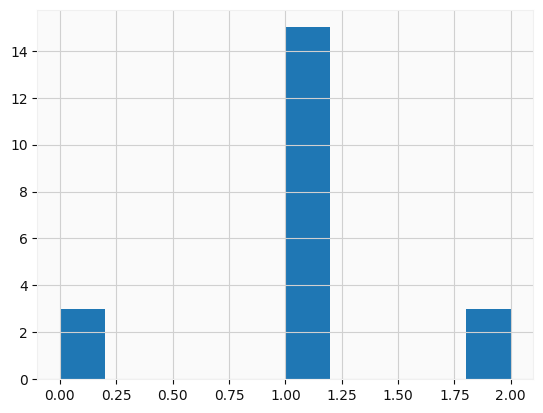

In [ ]:
# Предсказание скрытых состояний для каждого дня
states = pd.Series(model.predict(features), index=data.index[1:])
states.name = "state"

# Визуализация распределения состояний
states.hist()

Результатом model.predict() является массив целых чисел (0, 1 или 2), представляющих предсказанное состояние для каждого дня. Построение гистограммы этих состояний дает представление о том, как часто рынок находился в каждом из трех режимов за весь период анализа.

Для более наглядной визуализации можно раскрасить график цены в соответствии с предсказанными режимами.

Shape of features: (21, 2)


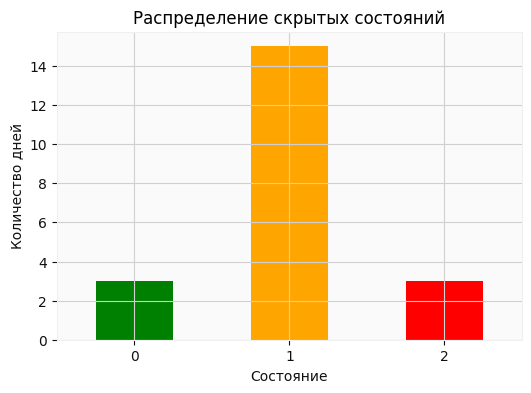

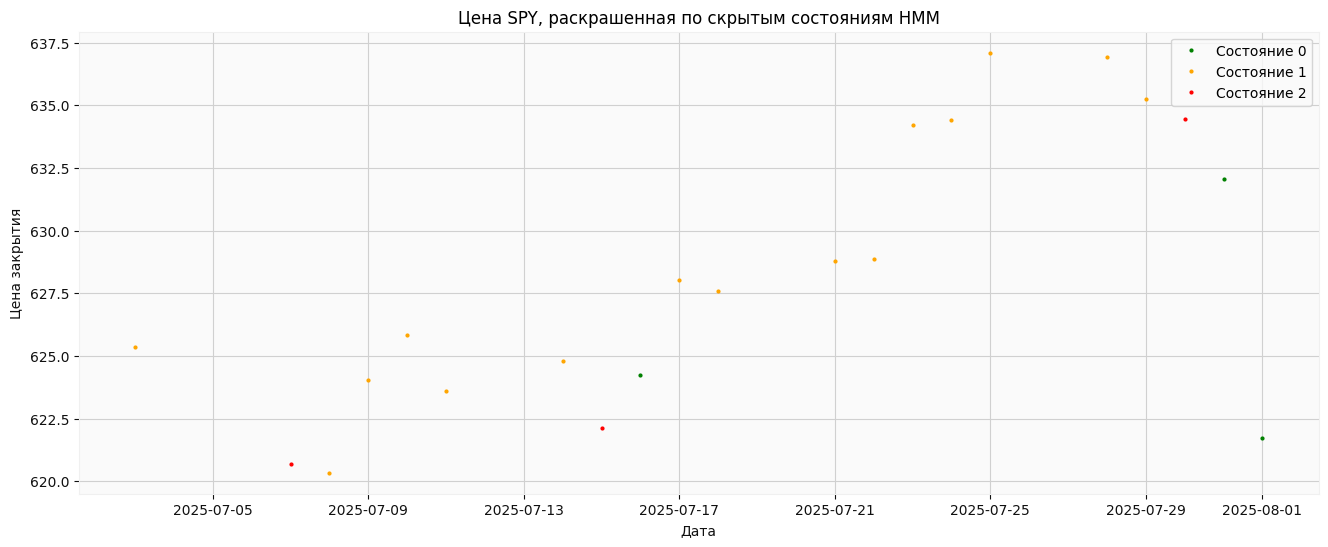

In [ ]:
# Шаг 3: предсказание скрытых состояний и визуализация
# ----------------------------------------------------

# Убедитесь, что features — это 2-D (T, 2)
print("Shape of features:", features.shape)

# Предсказание состояний
states = model.predict(features)  # (T,)
states = np.asarray(states).ravel()  # страхуемся — явно 1-D

# 1. Гистограмма состояний
plt.figure(figsize=(6, 4))
pd.Series(states).value_counts().sort_index().plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Распределение скрытых состояний')
plt.xlabel('Состояние')
plt.ylabel('Количество дней')
plt.xticks(rotation=0)
plt.show()

# 2. График цены SPY, раскрашенный по состояниям
# Убедитесь, что data['Close'] — это Series, а не DataFrame
close_series = data['Close'].iloc[1:]  # (T,) Series
close_series = close_series.squeeze()  # гарантированно 1-D

df_plot = pd.DataFrame({
    'Close': close_series.values,      # (T,) 1-D numpy array
    'state': states                   # (T,) 1-D numpy array
}, index=close_series.index)          # правильный DatetimeIndex

# print("Close type:", type(df_plot['Close'])) # должно быть 1-D
# print("Close shape:", df_plot['Close'].shape) № 1-D Series
# print("Index type:", type(df_plot.index)) # 1-D DatetimeIndex
# Если df_plot['Close'] — это DataFrame или 2-D массив, добавьте:
# df_plot['Close'] = df_plot['Close'].squeeze()

colors = {0: 'green', 1: 'orange', 2: 'red'}
plt.figure(figsize=[16, 6])
for s, color in colors.items():
    mask = df_plot['state'] == s
    plt.plot(df_plot.index[mask], df_plot['Close'][mask],
             '.', color=color, label=f'Состояние {s}', markersize=4)

plt.title('Цена SPY, раскрашенная по скрытым состояниям HMM')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.legend()
plt.grid(True)
plt.show()

Этот код создает график, на котором цена закрытия SPY отображается разными цветами в зависимости от предсказанного режима. Это позволяет визуально оценить, насколько хорошо модель справилась с идентификацией различных фаз рынка, таких как восходящие тренды (зеленый), нисходящие тренды (красный) и боковые движения (оранжевый) . Эта визуализация является мощным инструментом для понимания динамики рынка и может быть использована для разработки адаптивных торговых стратегий, которые изменяют свое поведение в зависимости от текущего режима.

Ниже представлена замена раздела «точечный график» шага 3. Она рисует график японских свечей (OHLC) вместо разбросанных точек, сохраняя ту же цветовую схему для трех скрытых режимов.

In [ ]:
# !pip install mplfinance

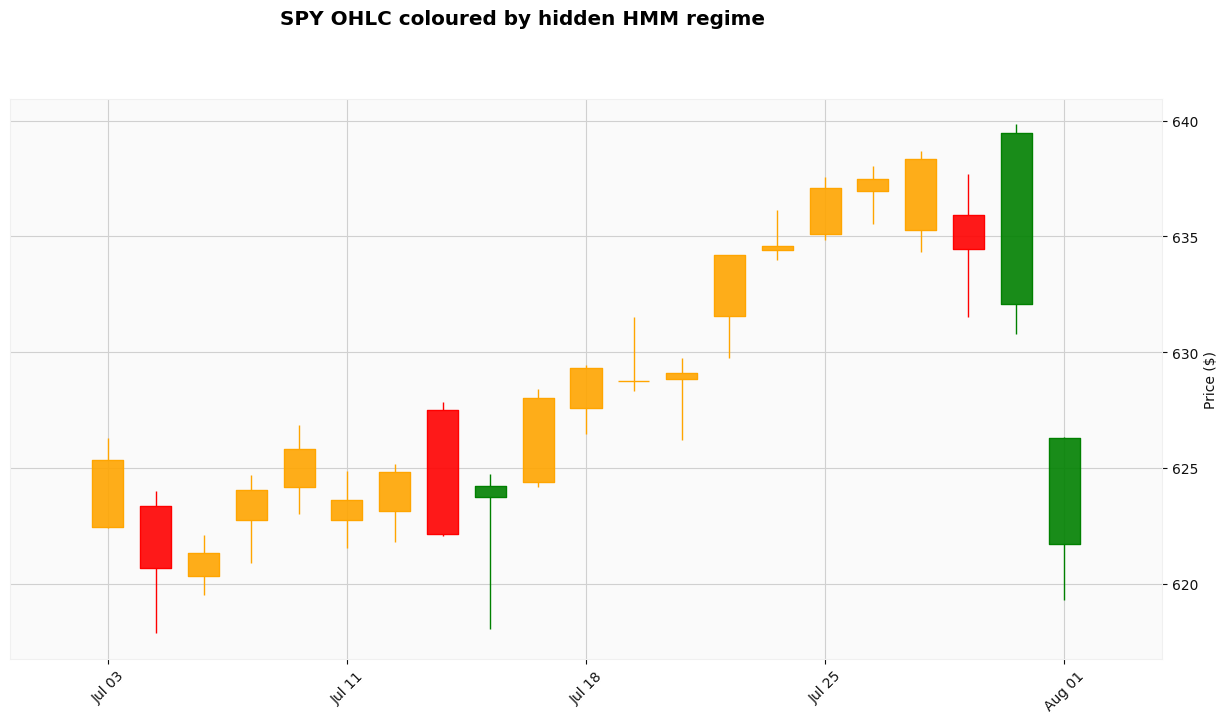

In [ ]:
# 1) Сбросить MultiIndex в обычные названия
ohlc = data[['Open', 'High', 'Low', 'Close', 'Volume']].iloc[1:]
ohlc.columns = ohlc.columns.droplevel(1)   # убираем уровень 'SPY'

# 2) Добавляем режимы и цвета
ohlc['state'] = states
colour_map = {0: 'green', 1: 'orange', 2: 'red'}
ohlc['colour'] = ohlc['state'].map(colour_map)

# 3) Строим свечной график
import mplfinance as mpf
mpf.plot(
    ohlc,
    type='candle',
    style='yahoo',
    marketcolor_overrides=ohlc['colour'].tolist(),
    figsize=(16, 8),
    title='SPY OHLC coloured by hidden HMM regime',
    ylabel='Price ($)'
)

marketcolor_overrides позволяет назначить определенный цвет каждому столбцу; здесь мы используем цвета режима, которые мы уже вычислили (зеленый, оранжевый, красный).




---



### Почему доля каждого состояния изменяется при каждой новой генерации?
Потому что сама модель стохастическая:
- GaussianHMM инициализирует параметры случайным образом;
- EM-алгоритм (E-step + M-step) может сойтись к разным локальным максимумам правдоподобия;
- данные короткие (всего 21 день), поэтому различные стартовые приближения заметно меняют финальные вероятности перехода и распределение состояний.

Как сделать разбиение воспроизводимым
1. Зафиксируйте seed перед обучением:

```
import numpy as np
np.random.seed(42)          # любое целое
model = hmm.GaussianHMM(
        n_components=3,
        covariance_type="full",
        n_iter=1000,
        random_state=42)    # то же самое
```
2. Увеличьте количество данных (длиннее период загрузки) – тогда случайность влияет меньше.

С фиксированным random_state доли состояний будут одинаковыми при каждом запуске.

